In [1]:
# Cell 1: install dependencies (if not available)
# !pip install timm ptflops --quiet

import os, shutil, time, random, copy
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.preprocessing import label_binarize

import torch
from torch import nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, models, transforms
from torchvision.utils import make_grid
from PIL import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [2]:
# Cell 2: Resize dataset to 128x128 once for faster training
SRC_DIR = '/kaggle/input/betel/Controlled Environment'  # original dataset
RESIZED_DIR = '/kaggle/working/betel_leaf_resized_128'

if not os.path.exists(RESIZED_DIR):
    os.makedirs(RESIZED_DIR, exist_ok=True)
    for cls in os.listdir(SRC_DIR):
        src_cls = os.path.join(SRC_DIR, cls)
        dst_cls = os.path.join(RESIZED_DIR, cls)
        os.makedirs(dst_cls, exist_ok=True)
        for fname in tqdm(os.listdir(src_cls), desc=f"Resizing {cls}"):
            img = Image.open(os.path.join(src_cls, fname)).convert("RGB")
            img = img.resize((128, 128))
            img.save(os.path.join(dst_cls, fname))
else:
    print("✅ Already resized, skipping...")


Resizing Healthy: 100%|██████████| 333/333 [03:31<00:00,  1.57it/s]


In [3]:
# Cell 3: define transforms & dataset
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

train_tf = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])
test_tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

dataset = datasets.ImageFolder(RESIZED_DIR, transform=train_tf)
class_names = dataset.classes
n_classes = len(class_names)
print("Classes:", class_names, "| Total:", len(dataset))


Classes: ['Diseased', 'Dried', 'Healthy'] | Total: 893


In [4]:
# Cell 4: helper functions
def create_split(dataset, ratio):
    """Create train/val/test splits given ratio=(train_frac, test_frac)"""
    n_total = len(dataset)
    n_train = int(ratio[0] * n_total)
    n_test = n_total - n_train
    train_subset, test_subset = random_split(dataset, [n_train, n_test], generator=torch.Generator().manual_seed(42))

    # 10% of train for validation
    n_val = int(0.1 * len(train_subset))
    n_train_final = len(train_subset) - n_val
    train_ds, val_ds = random_split(train_subset, [n_train_final, n_val], generator=torch.Generator().manual_seed(42))

    val_ds.dataset.transform = test_tf
    test_subset.dataset.transform = test_tf
    return train_ds, val_ds, test_subset

def build_vgg16(num_classes):
    model = models.vgg16(weights="IMAGENET1K_V1")
    num_features = model.classifier[6].in_features
    model.classifier[6] = nn.Linear(num_features, num_classes)
    return model.to(device)


In [5]:
# Cell 5: training and evaluation (no early stopping)
def train_model(model, train_loader, val_loader, epochs=50, lr=1e-4):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    for epoch in range(epochs):
        model.train()
        train_loss, train_correct = 0, 0
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * imgs.size(0)
            train_correct += (outputs.argmax(1) == labels).sum().item()

        val_loss, val_correct = 0, 0
        model.eval()
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * imgs.size(0)
                val_correct += (outputs.argmax(1) == labels).sum().item()

        train_loss /= len(train_loader.dataset)
        val_loss /= len(val_loader.dataset)
        train_acc = train_correct / len(train_loader.dataset)
        val_acc = val_correct / len(val_loader.dataset)

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        print(f"Epoch [{epoch+1}/{epochs}]  TrainAcc={train_acc:.3f}  ValAcc={val_acc:.3f}")
    return model, history


In [6]:
# Cell 6: evaluation function
def evaluate_model(model, loader):
    model.eval()
    y_true, y_pred, y_probs = [], [], []

    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            probs = torch.softmax(outputs, dim=1)
            preds = probs.argmax(1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_probs.extend(probs.cpu().numpy())

    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
    roc_auc = roc_auc_score(label_binarize(y_true, classes=list(range(n_classes))),
                            np.array(y_probs), multi_class='ovr')

    return acc, cm, report, roc_auc


In [7]:
# Cell 7: train & evaluate for all ratios
ratios = [(0.9,0.1), (0.8,0.2), (0.7,0.3), (0.6,0.4), (0.5,0.5),
          (0.4,0.6), (0.3,0.7), (0.2,0.8), (0.1,0.9)]

results = []

for tr, te in ratios:
    print(f"\n🚀 Training with ratio {int(tr*100)}:{int(te*100)} ...")
    train_ds, val_ds, test_ds = create_split(dataset, (tr, te))

    train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=2)
    test_loader = DataLoader(test_ds, batch_size=32, shuffle=False, num_workers=2)

    model = build_vgg16(n_classes)
    start = time.time()
    model, hist = train_model(model, train_loader, val_loader, epochs=50)
    train_time = time.time() - start

    acc, cm, report, roc_auc = evaluate_model(model, test_loader)
    results.append({
        'Ratio': f"{int(tr*100)}:{int(te*100)}",
        'TestAcc': acc,
        'ROC-AUC': roc_auc,
        'Precision': np.mean([report[c]['precision'] for c in class_names]),
        'Recall': np.mean([report[c]['recall'] for c in class_names]),
        'F1': np.mean([report[c]['f1-score'] for c in class_names]),
        'TrainTime(min)': train_time/60
    })

df_results = pd.DataFrame(results)
print("\n✅ Summary of all ratios:\n")
display(df_results)



🚀 Training with ratio 90:10 ...


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 235MB/s]


Epoch [1/50]  TrainAcc=0.840  ValAcc=0.988
Epoch [2/50]  TrainAcc=0.942  ValAcc=1.000
Epoch [3/50]  TrainAcc=0.968  ValAcc=0.988
Epoch [4/50]  TrainAcc=0.982  ValAcc=0.975
Epoch [5/50]  TrainAcc=0.985  ValAcc=0.988
Epoch [6/50]  TrainAcc=0.992  ValAcc=0.988
Epoch [7/50]  TrainAcc=0.997  ValAcc=0.975
Epoch [8/50]  TrainAcc=1.000  ValAcc=1.000
Epoch [9/50]  TrainAcc=1.000  ValAcc=1.000
Epoch [10/50]  TrainAcc=1.000  ValAcc=1.000
Epoch [11/50]  TrainAcc=1.000  ValAcc=1.000
Epoch [12/50]  TrainAcc=1.000  ValAcc=1.000
Epoch [13/50]  TrainAcc=1.000  ValAcc=1.000
Epoch [14/50]  TrainAcc=1.000  ValAcc=1.000
Epoch [15/50]  TrainAcc=1.000  ValAcc=1.000
Epoch [16/50]  TrainAcc=1.000  ValAcc=1.000
Epoch [17/50]  TrainAcc=1.000  ValAcc=1.000
Epoch [18/50]  TrainAcc=1.000  ValAcc=1.000
Epoch [19/50]  TrainAcc=1.000  ValAcc=1.000
Epoch [20/50]  TrainAcc=1.000  ValAcc=1.000
Epoch [21/50]  TrainAcc=1.000  ValAcc=1.000
Epoch [22/50]  TrainAcc=1.000  ValAcc=1.000
Epoch [23/50]  TrainAcc=1.000  ValAcc=1.0

,Ratio,TestAcc,ROC-AUC,Precision,Recall,F1,TrainTime(min)
0,90:10,0.966667,0.995128,0.966583,0.960688,0.963411,4.086435
1,80:20,0.966480,0.998833,0.958517,0.965068,0.961448,3.744490
2,70:30,0.970149,0.996248,0.967337,0.966892,0.967098,3.317273
3,60:40,0.955307,0.993754,0.949222,0.956617,0.951817,2.879715
4,50:50,0.968680,0.997920,0.967182,0.963494,0.965192,2.440363
5,40:60,0.960821,0.991326,0.956768,0.956135,0.956325,2.005527
6,30:70,0.960064,0.992725,0.955196,0.956995,0.956002,1.542388
7,20:80,0.955245,0.988415,0.948999,0.954423,0.951010,1.103319
8,10:90,0.946517,0.986651,0.938407,0.944822,0.940676,0.645261


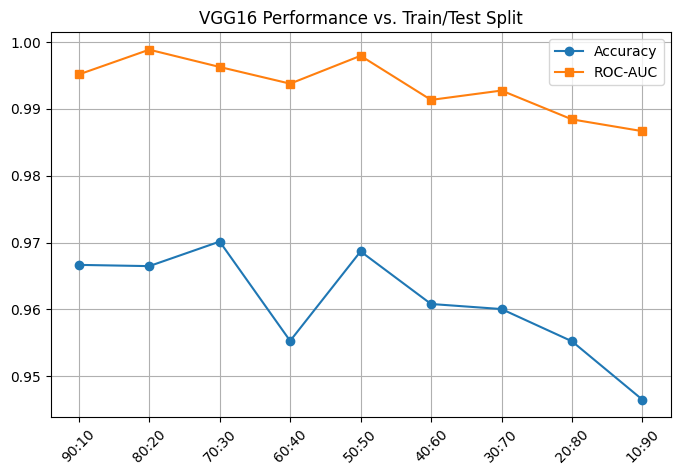

In [8]:
# Cell 8: plot results
plt.figure(figsize=(8,5))
plt.plot(df_results['Ratio'], df_results['TestAcc'], marker='o', label='Accuracy')
plt.plot(df_results['Ratio'], df_results['ROC-AUC'], marker='s', label='ROC-AUC')
plt.xticks(rotation=45)
plt.grid(True)
plt.title("VGG16 Performance vs. Train/Test Split")
plt.legend()
plt.show()
